In [23]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from scipy import optimize

from astroML import stats as astroMLstats

import sklearn
from sklearn.mixture import GaussianMixture

## Black-hole binary formation channels with gaussian mixtures.

Many problems in astrophysics give rise to data with multiple modes. This is typically because different processes physical processes contribute to the observed dataset. 

For instance, one of the most outstanding question in gravitational-wave astrophysics is the formation channel of binary black holes. Leading scenarions include the evolution of isolated binaries in the galactic field and the dynamica assembly of sources in dense environments like globular clusters.

Anyway. LIGO measures the masses of many black holes. You can find the dataset at `solutions/formationchannels.npy`.


*Hint*: Note that the data provided are of shape (N,1), not (N,). This might be confusing at first, but it's the format that sklearn wants (more on this in a future lecture).  A useful tool to convert between the two is [np.newaxis](https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it).

Some events form in different astrophysical environments than others. **You want to figure out how many of formation channels are at play.**


The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of $N$ gaussians each with mean $\mu_j$ and standard deviation $\sigma_j$ and weight $\alpha_j$:

$p(x_i|\theta) = \sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j) $

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_j$ must be unity to ensure that this is a probability.

#### Tasks

1) Load this file (`np.load`) and complete a quick exploration of the data. How many modes do you think you see?

data shape: (2950, 1)


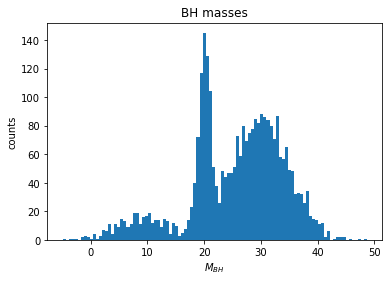

In [22]:
data = np.load("formationchannels.npy")

print('data shape:',data.shape)

plt.hist(data,bins=100)
plt.title(r'BH masses')
plt.xlabel(r'$M_{BH}$')
plt.ylabel('counts')
plt.show()

2) Take some time to explore `sklearn.mixture.GaussianMixture`. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

*Note*. We'll do a more formal introduction to scikit-learn in one of the next lectures. This is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens *all the time* in scientific research!

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Note: `sklearn` by default will use the so-called [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is one of the many great things in data science we don't have time to study in detail.

4) For each of this fits, compute the AIC (easy! It's a attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

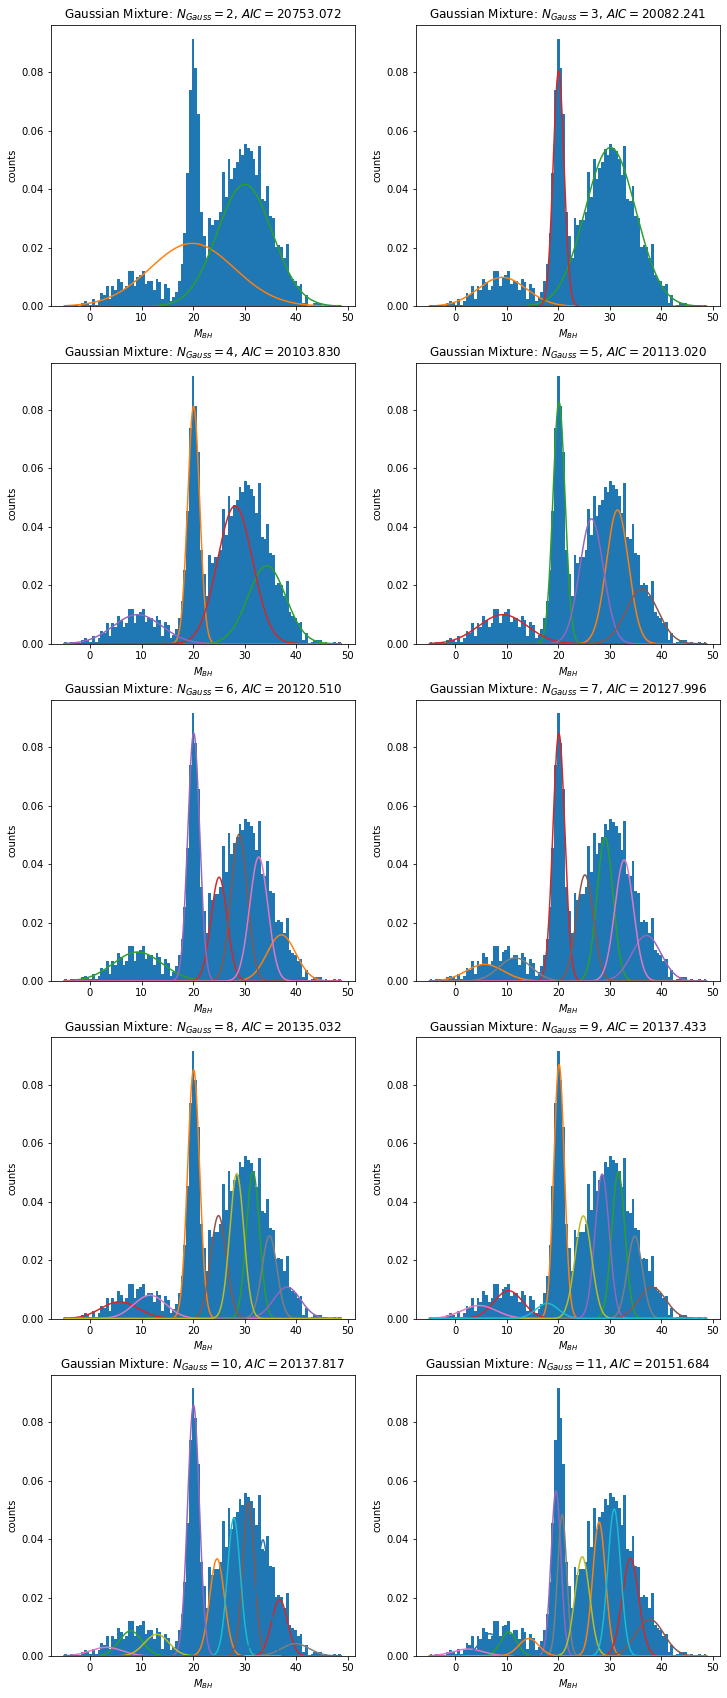

In [110]:
N_Gauss = np.arange(2,12) # why it doesn't work with N=1?
gm_fit = np.empty([len(N_Gauss)],dtype=object)
Gaussians = np.empty([len(N_Gauss),3],dtype=object) # mu,sigma,alpha
AIC = np.zeros(len(N_Gauss))

for i in range(len(N_Gauss)):
    # define the Gaussian Mixture model:
    GM_model = GaussianMixture(n_components=N_Gauss[i])
    
    # train the model with the data:
    gm = GM_model.fit(data)
    gm_fit[i] = gm
    
    # fill an array with the means and the std of the Gaussians identified
    Gaussians[i] = gm.means_, np.sqrt(gm.covariances_),gm.weights_
    
    # get the AIC
    AIC[i] = gm.aic(data)
    
    
# plot
fig,ax = plt.subplots(nrows=5,ncols=2,figsize=(12,30))

x_grid = np.linspace(min(data),max(data),1000)

for i in range(len(N_Gauss)):
    ax = ax.ravel()
    ax[i].hist(data,bins=100,density=True)
    ax[i].set_title(r'Gaussian Mixture: $N_{Gauss}=%i$, $AIC=%.3f$'%(N_Gauss[i],AIC[i]))
    ax[i].set_xlabel(r'$M_{BH}$')
    ax[i].set_ylabel('counts')
    for j in range(N_Gauss[i]):
        # define the Gaussian with the mu and sigma extrapolated from GM
        mu = Gaussians[i][0][j]
        sigma = Gaussians[i][1][j]
        alpha = Gaussians[i][2][j]
        
        gauss_pdf = scipy.stats.norm(mu,sigma)
        
        # draw the Gaussian over the x_grid range
        ax[i].plot(x_grid,alpha*gauss_pdf.pdf(x_grid))

Text(0, 0.5, 'AIC')

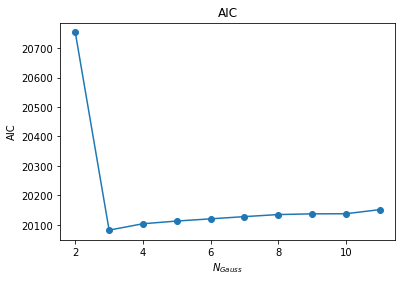

In [211]:
# plot the AIC:
plt.plot(N_Gauss,AIC)
plt.scatter(N_Gauss,AIC)
plt.title('AIC')
plt.xlabel(r'$N_{Gauss}$')
plt.ylabel('AIC')

5) Plot the preferred solution on top of the input data. You should get a very nice fit!

Best GM model: N=3 Gaussians


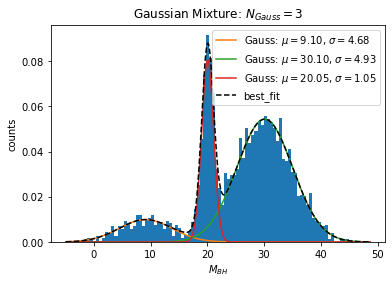

In [228]:
best_gm_model = N_Gauss[np.argmin(AIC)]
print('Best GM model: N=%i Gaussians'%best_gm_model)

mu_best = Gaussians[np.argmin(AIC)][0]
sigma_best = Gaussians[np.argmin(AIC)][1]
alpha_best = Gaussians[np.argmin(AIC)][2]
best_fit = gm_fit[np.argmin(AIC)]

log_L =  best_fit.score_samples(x_grid.reshape(-1,1)) # Log-likelihood of each sample in data under the current model
best_pdf = np.exp(log_L)

# plot
plt.hist(data,bins=100,density=True)

for i in range(best_gm_model):
    best_gauss = scipy.stats.norm(mu_best[i][0],sigma_best[i][0])
    plt.plot(x_grid,(alpha_best[i])*best_gauss.pdf(x_grid),label='Gauss: $\mu=%.2f$, $\sigma=%.2f$'%(mu_best[i][0],sigma_best[i][0]))
    
plt.plot(x_grid, best_pdf,color='black',ls='--',label='best_fit')
    
plt.title(r'Gaussian Mixture: $N_{Gauss}=%i$'%(best_gm_model))
plt.xlabel(r'$M_{BH}$')
plt.ylabel('counts')

plt.legend()
plt.show()

6) Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

*Hint:* Useful methods here are `score_samples` and `predict_proba`: you'll need them both. Try to understand what they do and how you can put them together.

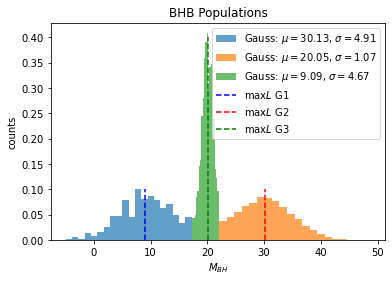

In [215]:
predict_proba = best_fit.predict_proba(data) # probability of each data point to belong to one of the Gaussians
score_samples =  best_fit.score_samples(data) # Log-likelihood of each sample in data under the current model

# try to separate the different Gaussians:
belong_idx = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    max_prob = np.argmax(predict_proba[i])
    belong_idx[i] = max_prob

# determine the Gaussian population
Gauss1 = data[belong_idx==0]
Gauss2 = data[belong_idx==1]
Gauss3 = data[belong_idx==2]

# separate the Likelihood of the different Gaussians
L_G1 = score_samples[belong_idx==0]
L_G2 = score_samples[belong_idx==1]
L_G3 = score_samples[belong_idx==2]

# let's now try to get the maximum Likelihood for each distribution:
max_LG1 = Gauss1[np.argmax(L_G1)]
max_LG2 = Gauss2[np.argmax(L_G2)]
max_LG3 = Gauss3[np.argmax(L_G3)]

#plot -------------------------------------------------------------------------------------------------------------------

plt.hist(Gauss1,density=True,bins=20,alpha=0.7,label='Gauss: $\mu=%.2f$, $\sigma=%.2f$'%(mu_best[0][0],sigma_best[0][0]))
plt.hist(Gauss2,density=True,bins=20,alpha=0.7,label='Gauss: $\mu=%.2f$, $\sigma=%.2f$'%(mu_best[1][0],sigma_best[1][0]))
plt.hist(Gauss3,density=True,bins=20,alpha=0.7,label='Gauss: $\mu=%.2f$, $\sigma=%.2f$'%(mu_best[2][0],sigma_best[2][0]))

plt.vlines(max_LG1,0,0.1,color='blue',ls='--',label='$\max{L}$ G%i'%1)
plt.vlines(max_LG2,0,0.1,color='red',ls='--',label='$\max{L}$ G%i'%2)
plt.vlines(max_LG3,0,0.4,color='green',ls='--',label='$\max{L}$ G%i'%3)

#plt.plot(np.sort(data),np.exp(score_samples[np.argsort(data)]))

plt.title('BHB Populations')
plt.xlabel(r'$M_{BH}$')
plt.ylabel('counts')
plt.legend()
plt.show()